In [3]:
import cartopy.crs as ccrs
from cgeniepy.foram import ForamModel as fm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def int_biomass_ts(model_path):
    "integrated foraminifera biomass time series"
    model = fm(model_path)
    time = model.select_var("time").array.values - 4.5
    foram_names = ["bn", "bs", "sn", "ss"]
    data = []

    for iyear in range(len(time)):
        state_foram = 0
        for foram in foram_names:
            state_foram += model.select_foramtype(foram).biomass().isel(time=iyear).sum().magnitude
        data.append(state_foram)
    return time, data

def sst_ts(model_path):
    model = fm(model_path)
    time = model.select_var("time").array
    mean_sst, sd_sst = [],[]
    for iyear in range(len(time)):
        mean_sst.append(model.select_var("ocn_sur_temp").isel(time=iyear).nanmean())
        sd_sst.append(model.select_var("ocn_sur_temp").isel(time=iyear).nansd())
    return mean_sst, sd_sst

def cal_ratio(a1, a2, thershold):
    ratio = np.divide(a1, a2, out=np.zeros_like(a1))
    ratio = (ratio - 1)*100
    ## if any value is smaller than threshold, set the ratio to 0
    ratio[np.where(a2 < thershold)] = 0
    return ratio

def get_assemblage(model_path, year):
    model = fm(model_path)
    return np.array([model.select_foramtype("bn").relative_abundance(threshold=0).take(year, axis=0).array,
                     model.select_foramtype("bs").relative_abundance(threshold=0).take(year, axis=0).array,
                     model.select_foramtype("sn").relative_abundance(threshold=0).take(year, axis=0).array,
                     model.select_foramtype("ss").relative_abundance(threshold=0).take(year, axis=0).array])

from cgeniepy.grid import GENIE_grid_vol
def get_npp(model_path):
    vol = GENIE_grid_vol() * 1E9
    d_to_y = 365
    mmol_to_g = 12 * 1E-3
    g_to_Pg = 1E-15
    model = fm(model_path)
    time = model.select_var("time").array
    data = []
    for iyear in range(len(time)):
        npp_rate = model.select_var("eco2D_Uptake_Fluxes_C").isel(time=iyear).array
        npp_total = np.nansum(npp_rate * vol * d_to_y * mmol_to_g * g_to_Pg)
        data = np.append(data, npp_total)
    return data

from cgeniepy.foram import scd
def dissimilarity(model_path):
    model = fm(model_path)
    time = model.select_var("time").array
    data = []
    for iyear in range(len(time)):
        init_year = get_assemblage("../model/muffin.CBE.worlg4.BASESFeTDTL.historical", 1)
        current_year = get_assemblage(model_path, iyear)
        scd_value = scd(current_year, init_year).nanmean()
        data.append(scd_value)
    return data

In [4]:
## plot pre-industrial age to future
mod_paths = [
    "../model/muffin.CBE.worlg4.BASESFeTDTL.historical",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.1p5deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.2deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.3deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg",
]

# Store the temporary dataframes in a list
dfs = []

# Iterate over each model path and retrieve the data
for path in mod_paths:
    time_data, biomass_data = int_biomass_ts(path)
    sst_mean, sst_sd = sst_ts(path)
    npp = get_npp(path)
    # Create a temporary dataframe for each model's data
    temp_df = pd.DataFrame({"time": time_data, "biomass": biomass_data,
                           "sst_mean": sst_mean, "sst_sd": sst_sd,
                            "npp": npp})
    temp_df['age'] = path.split(".")[-1]
    temp_df['age'] = temp_df['age'].str.replace("deg", " °C")
    temp_df['age'] = temp_df['age'].str.replace("1p5", "1.5")

    dfs.append(temp_df)

# Concatenate the dataframes from the list
merged_df = pd.concat(dfs, ignore_index=True)

# Filter data after 1900
merged_df = merged_df[merged_df['time'] > 1900]

# Calculate biomass change relative to pre-industrial and convert to percentage
merged_df['biomass'] = merged_df['biomass'] / merged_df['biomass'].iloc[0] * 100 - 100

# Calculate SST change relative to pre-industrial
merged_df['sst_mean'] = merged_df['sst_mean'] - merged_df['sst_mean'].iloc[0]

# Calculate NPP change relative to pre-industrial
merged_df['npp'] = merged_df['npp'] / merged_df['npp'].iloc[0] * 100 - 100

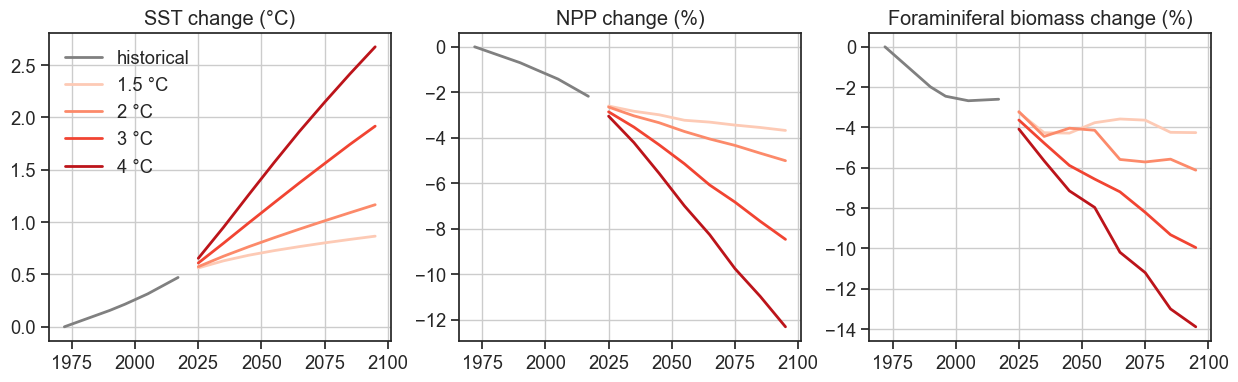

In [7]:
# Plot the data using seaborn
## generate figure
fig, axs = plt.subplots(figsize=(15, 4), nrows=1, ncols=3, sharex=True)

sns.set_style("ticks",{'axes.grid' : True})

sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2})

# Define the shades of red for the 'Reds' color palette
reds_palette = sns.color_palette("Reds", n_colors=4)
# Add grey as the first color in the palette
custom_palette = ["#808080"] + reds_palette

sns.lineplot(data=merged_df, x="time", y="sst_mean", hue="age", ax=axs[0], palette=custom_palette)
sns.lineplot(data=merged_df, x="time", y="npp", hue="age", ax=axs[1], legend=False, palette=custom_palette)
sns.lineplot(data=merged_df, x="time", y="biomass", hue="age", ax=axs[2], legend=False, palette=custom_palette)

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("")

axs[0].legend(title="", frameon=False)
axs[0].set_title("SST change (°C)")
axs[1].set_title("NPP change (%)")
axs[2].set_title("Foraminiferal biomass change (%)")

## export figure
plt.savefig("../output/foram_biomass_ts.jpg", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()

/var/folders/rq/vks10_qx2l9b08d_pygvwfzh0000gn/T/ipykernel_33588/3114005048.py:32: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(a1, a2, out=np.zeros_like(a1))
/var/folders/rq/vks10_qx2l9b08d_pygvwfzh0000gn/T/ipykernel_33588/3114005048.py:32: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(a1, a2, out=np.zeros_like(a1))


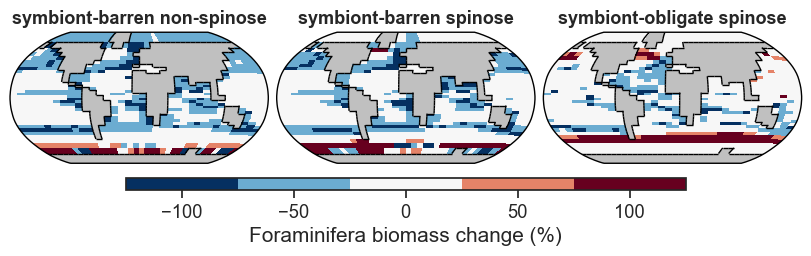

In [4]:
## Create figure and axes
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5),
                        subplot_kw={'projection': ccrs.Robinson()},
                        constrained_layout=True)

modern = fm("../model/muffin.CBE.worlg4.BASESFeTDTL.historical")
future4 = fm("../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg")

fnames = ['symbiont-barren non-spinose',
          'symbiont-barren spinose',
          'symbiont-obligate spinose']

cmap = plt.get_cmap("RdBu_r",5)
for i, foramtype in enumerate(["bn", "bs", "ss"]):
    axs[i].set_title(fnames[i], fontsize=13, fontweight="bold")
    modern_biomass = modern.select_foramtype([foramtype]).biomass(combine_vars=True).take(-1, axis=0)
    future_biomass = future4.select_foramtype([foramtype]).biomass(combine_vars=True).take(-1, axis=0)
    diff = future_biomass - modern_biomass ## a fake diff, will change the value using cal_ratio
    diff.array = cal_ratio(future_biomass.array, modern_biomass.array, 1e-10)
    p = diff.plot_map(ax=axs[i], cmap=cmap, vmin=-125, vmax=125, colorbar=False)

# Add color bar on the bottom side of the figure
cax = fig.add_axes([0.15, 0.13, 0.7, 0.05])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal', fraction=0.05)
cbar.set_label(r"Foraminifera biomass change (%)", fontsize=15)

# Save the figure
fig.savefig("../output/fig2a.jpg", dpi=300, bbox_inches="tight")